In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        image_path = os.path.join(self.path, "input/", id_name) + ".jpg"
        #print(image_path)
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        image = image / 255.0
        
        return image
    
    def __getitem__(self, index):
        if(index + 1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
            
        files_batch = self.ids[index*self.batch_size : (index + 1)*self.batch_size]
        
        image = []
        
        for id_name in files_batch:
            _img = self.__load__(id_name)
            image.append(_img)
            
            
        image = np.array(image)   
            
        return image
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [3]:
image_size = 256
image_path = "dataset/DFNet_ellipse/"
batch_size = 1

flist_path = image_path + "input/flist"
all_ids = open(flist_path).read().splitlines()

print (len(all_ids))

1228


In [4]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [5]:
def UNet():
    f = [16, 32, 64, 128, 256, 512]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #256 -> 128
    c2, p2 = down_block(p1, f[1]) #128 -> 64
    c3, p3 = down_block(p2, f[2]) #64 -> 32
    c4, p4 = down_block(p3, f[3]) #32 -> 16
    c5, p5 = down_block(p4, f[4]) #16->8
    
    bn = bottleneck(p5, f[5])
    
    u1 = up_block(bn, c5, f[4]) #8 -> 16
    u2 = up_block(u1, c4, f[3]) #16 -> 32
    u3 = up_block(u2, c3, f[2]) #32 -> 64
    u4 = up_block(u3, c2, f[1]) #64 -> 128
    u5 = up_block(u4, c1, f[0]) #128 -> 256
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u5)
    model = keras.models.Model(inputs, outputs)
    return model

In [7]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_23[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_24[0][0]                  
____________________________________________________________________________________________

In [12]:
model.load_weights("DFNet_UnetW_5_10_ellipse.h5")
allgen = DataGen(all_ids, image_path, batch_size=batch_size, image_size=image_size)

result_path = "dataset/DFNet_ellipse/5_10_detected_020/"
for id in range(len(all_ids)):
    x = allgen.__getitem__(id)
    result = model.predict(x)
    result = result > 0.20
    img = np.reshape(result[0]*255, (image_size, image_size))
    cv2.imwrite(result_path +  all_ids[id] + "_detected" + ".png", img)

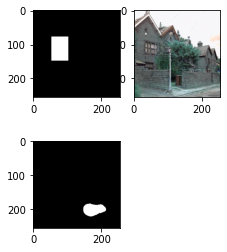

In [18]:
iter = 0

fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.5)

ax = fig.add_subplot(2, 1, 1)
ax.imshow(np.reshape(y[iter]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(2, 1, 2)
ax.imshow(np.reshape(result[iter]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(2, 2, 2)
ax.imshow(x[iter])

In [ ]:
=